In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
import torch.autograd as autograd
import torch.nn as nn
import matplotlib.pyplot as plt
from numpy import format_float_scientific as ffs
import sys
sys.path.append("..")
import time as Time
torch.set_default_dtype(torch.float64)
torch.set_printoptions(precision=10)
device = 'cpu'

In [2]:
%load_ext autoreload
%autoreload 2
from Forward_Parameter import a, a_b, dc, b, sigma, k, eta, vpl, statepl,t1, t2, v_ini, state_ini, time_span

In [3]:
from PINN_Preparation import Training_Tensor
collocation_points = np.arange(t1, t2, time_span) - t1
collocation_points = collocation_points.reshape([1, -1])
Tensors = Training_Tensor(collocation_points, vpl, statepl, v_ini, state_ini)
Nt, ub, lb, t_ini_train, u_ini_train, t_f_train, t_test_tensor, f_hat = Tensors.Output()

In [4]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        self.loss_hist = []
        self.lossini_hist = []
        self.lossf_hist = []

        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)
            
    #foward computation
    def forward(self,t):
        
        if torch.is_tensor(t) != True:         
            t = torch.from_numpy(t)           
        
        u_b = torch.from_numpy(ub).double().to(device)
        l_b = torch.from_numpy(lb).double().to(device)
        t = (t - l_b)/(u_b - l_b)
        a = t.double() #convert to double
        for i in range(len(layers)-2):         
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        
        return a

    #loss function induced from initial condition
    def loss_IC(self,t,y):
        
        z = t.clone()
        z.requires_grad = True
        u = self.forward(z)
        loss_u = self.loss_function(u[0, :], y[0, :])#velocity and state
        u_0 = torch.reshape(u[:,0],(t.shape[0],1)) #v
        u_1 = torch.reshape(u[:,1],(t.shape[0],1)) #theta
        
        velocity = vpl * torch.exp(u_0)
        state    = statepl * torch.exp(u_1)
        
        if self.iter <= 9:
            print('step=',self.iter, "P_ini",u_0.item(),y[0,0].item())
            print('step=',self.iter, "Q_ini",u_1.item(),y[0,1].item())
            #print('step=',self.iter, "x_ini",u.item(),y[0,0].item())
        if self.iter % 100 == 0:
            print('step=',self.iter, "P_ini",u_0.item(),y[0,0].item())
            print('step=',self.iter, "Q_ini",u_1.item(),y[0,1].item())
            #print('step=',self.iter, "x_ini",u.item(),y[0,0].item())
                
        return loss_u, velocity, state

    #loss function induced from governing equation
    def loss_PDE(self, t):
                       
        z = t.clone()
        z.requires_grad = True
        
        u = self.forward(z)
        u_0 = torch.reshape(u[:,0],(t.shape[0],1)) #v
        u_1 = torch.reshape(u[:,1],(t.shape[0],1)) #state
        P_t = autograd.grad(u_0,z,torch.ones([t.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        Q_t = autograd.grad(u_1,z,torch.ones([t.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        velocity = vpl * torch.exp(u_0)
        state    = statepl * torch.exp(u_1)
        
        #Governing euqation
        eps = 1.0e-30
        p = a / (velocity + eps) + eta / sigma
        r = 1.0 - velocity * state / dc
        q = k / sigma * (vpl - velocity) - b * r / (state + eps)

        f_P = P_t - q / (p * velocity)
        f_Q = Q_t - r / state
        Lr = (f_P ** 2 + f_Q ** 2)[:, 0]
        t_ = z[:,0]
        loss_f = Lr[0]*(t_[1]-t_[0]) + Lr[-1]*(t_[-1]-t_[-2]) + torch.sum(Lr[1:-1]*(t_[2:]-t_[0:-2]))
        loss_f = loss_f / 2 * (dc / vpl)
  
        dv_dt = velocity * P_t 
        dstate_dt = state * Q_t
                
        return loss_f, dv_dt, dstate_dt

    def loss(self,t_ini_train,u_ini_train, t_f_train):

        loss_ini, v_ini, state_ini = self.loss_IC(t_ini_train,u_ini_train)
        loss_f, dv_dt, dstate_dt = self.loss_PDE(t_f_train)
        loss_val = loss_ini + weight*loss_f

        return loss_val, loss_ini, loss_f, dv_dt, dstate_dt, v_ini, state_ini
                                      
    def closure(self):
        
        optimizer.zero_grad()
        loss ,loss_ini, loss_f, dv_dt, dstate_dt, v_ini, state_ini = self.loss(t_ini_train,u_ini_train,t_f_train)
        self.loss_hist.append(loss.item())
        self.lossini_hist.append(loss_ini.item())
        self.lossf_hist.append(loss_f.item())
        loss.backward()        
        self.iter += 1
        
        if self.iter <= 9:
            _ = PINN.test()
            print('step=',self.iter, 'loss=', loss.item(),loss_ini.item(), loss_f.item())

        if self.iter % 100 == 0:
            _ = PINN.test()
            print('step=',self.iter, 'loss=', loss.item(),loss_ini.item(), loss_f.item())

        return loss
    
    def test(self):
                
        u_pred = self.forward(t_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
        u_pred = np.reshape(u_pred,(Nt,2),order='F')
                
        return u_pred

In [5]:
from PINN_Save import Save_Loss_forward, Save_PINN_forward
from Forward_Parameter import seed, max_iteration, epsilon, filename, save

start = Time.time()
torch.manual_seed(seed); np.random.seed(seed) #Fix seed 

weight = 1; layers = np.array([1,20,20,20,20,20,20,20,20,2])
PINN = Sequentialmodel(layers).to(device)

params = list(PINN.parameters())
optimizer = torch.optim.LBFGS(params, lr=1.0, 
                              max_iter = 1, 
                              max_eval = 100, 
                              tolerance_grad = 1e-20, 
                              tolerance_change = 1e-6 * 1e-6, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')

loss_list ={"total":[0], "ini":[], "ode":[]}

for i in range(max_iteration):
    optimizer.step(PINN.closure)
    Save_Loss_forward(PINN, loss_list)
    if(abs(loss_list["total"][-1] - loss_list["total"][-2]) < epsilon):
        break
del loss_list["total"][0]

Save_PINN_forward(PINN, filename, loss_list)

end = Time.time()
print("Traininig time = ", end - start, " [s]")

step= 0 P_ini 0.0 -1.7093871951979658
step= 0 Q_ini 0.0 1.4142093109815335
step= 0 P_ini 0.0 -1.7093871951979658
step= 0 Q_ini 0.0 1.4142093109815335
step= 1 loss= 2.5884467719751685 2.460996279186816 0.1274504927883526
step= 1 P_ini -0.012482003592325295 -1.7093871951979658
step= 1 Q_ini 0.16938478676922722 1.4142093109815335
step= 2 loss= 2.8816248882083126 2.214537662689285 0.6670872255190272
step= 2 P_ini -0.0044975393056302755 -1.7093871951979658
step= 2 Q_ini 0.06015672906399665 1.4142093109815335
step= 3 loss= 2.420312093247287 2.370053566683117 0.05025852656416981
step= 3 P_ini -0.0044975393056302755 -1.7093871951979658
step= 3 Q_ini 0.06015672906399665 1.4142093109815335
step= 4 loss= 2.420312093247287 2.370053566683117 0.05025852656416981
step= 4 P_ini -0.02550888272256504 -1.7093871951979658
step= 4 Q_ini 0.07752576894497229 1.4142093109815335
step= 5 loss= 2.35684592565445 2.3110845313882056 0.04576139426624426
step= 5 P_ini -0.11978314820161703 -1.7093871951979658
step= 5 

step= 3500 loss= 0.0008465866491354875 2.397782477434555e-06 0.000844188866658053
step= 3500 P_ini -1.7100041634803915 -1.7093871951979658
step= 3500 Q_ini 1.4121081410471041 1.4142093109815335
step= 3600 loss= 0.0006638699097157564 4.2435155043302146e-06 0.0006596263942114262
step= 3600 P_ini -1.7084515032103593 -1.7093871951979658
step= 3600 Q_ini 1.410676128240078 1.4142093109815335
step= 3700 loss= 0.0005796696506761616 9.059799841835221e-06 0.0005706098508343264
step= 3700 P_ini -1.7112375945314897 -1.7093871951979658
step= 3700 Q_ini 1.410375824058357 1.4142093109815335
step= 3800 loss= 0.0005275195781389555 1.1437651226367436e-05 0.0005160819269125881
step= 3800 P_ini -1.711666498124257 -1.7093871951979658
step= 3800 Q_ini 1.4100045421861138 1.4142093109815335
step= 3900 loss= 0.0004921074596985944 1.0492631188829717e-05 0.00048161482850976465
step= 3900 P_ini -1.7112423050628995 -1.7093871951979658
step= 3900 Q_ini 1.410397000865636 1.4142093109815335
step= 4000 loss= 0.0004493

step= 7700 loss= 3.933278975654191e-05 2.800762701355425e-06 3.653202705518649e-05
step= 7700 P_ini -1.7109321467741534 -1.7093871951979658
step= 7700 Q_ini 1.4124231662661944 1.4142093109815335
step= 7800 loss= 3.215384261485475e-05 1.306847138106876e-06 3.084699547674788e-05
step= 7800 P_ini -1.7104219697347744 -1.7093871951979658
step= 7800 Q_ini 1.412967161258599 1.4142093109815335
step= 7900 loss= 2.5385779703230442e-05 5.288576486006112e-07 2.485692205462983e-05
step= 7900 P_ini -1.7100352125903602 -1.7093871951979658
step= 7900 Q_ini 1.413411941464616 1.4142093109815335
step= 8000 loss= 2.3007239953395897e-05 9.617502985223033e-07 2.2045489654873593e-05
step= 8000 P_ini -1.7103775519636286 -1.7093871951979658
step= 8000 Q_ini 1.4132203774521916 1.4142093109815335
step= 8100 loss= 2.1849694018317672e-05 9.36796982726527e-07 2.0912897035591145e-05
step= 8100 P_ini -1.7103420263469982 -1.7093871951979658
step= 8100 Q_ini 1.4132285503367834 1.4142093109815335
step= 8200 loss= 2.1340

step= 11900 loss= 6.395686737888274e-06 7.451731523881138e-08 6.3211694226494625e-06
step= 11900 P_ini -1.7096547088641587 -1.7093871951979658
step= 11900 Q_ini 1.4139271907807862 1.4142093109815335
step= 12000 loss= 6.3389759229790484e-06 8.00649871193088e-08 6.25891093585974e-06
step= 12000 P_ini -1.7096580797954257 -1.7093871951979658
step= 12000 Q_ini 1.4139017712195132 1.4142093109815335
step= 12100 loss= 6.2205792555821895e-06 8.106617469398028e-08 6.139513080888209e-06
step= 12100 P_ini -1.7096806996061724 -1.7093871951979658
step= 12100 Q_ini 1.4139343124201547 1.4142093109815335
step= 12200 loss= 5.959064935609897e-06 1.2121347308702142e-07 5.837851462522876e-06
step= 12200 P_ini -1.709748504954892 -1.7093871951979658
step= 12200 Q_ini 1.4139055665824283 1.4142093109815335
step= 12300 loss= 5.709740917588137e-06 8.660147530527844e-08 5.623139442282858e-06
step= 12300 P_ini -1.7096846726884194 -1.7093871951979658
step= 12300 Q_ini 1.4139121876906904 1.4142093109815335
step= 124

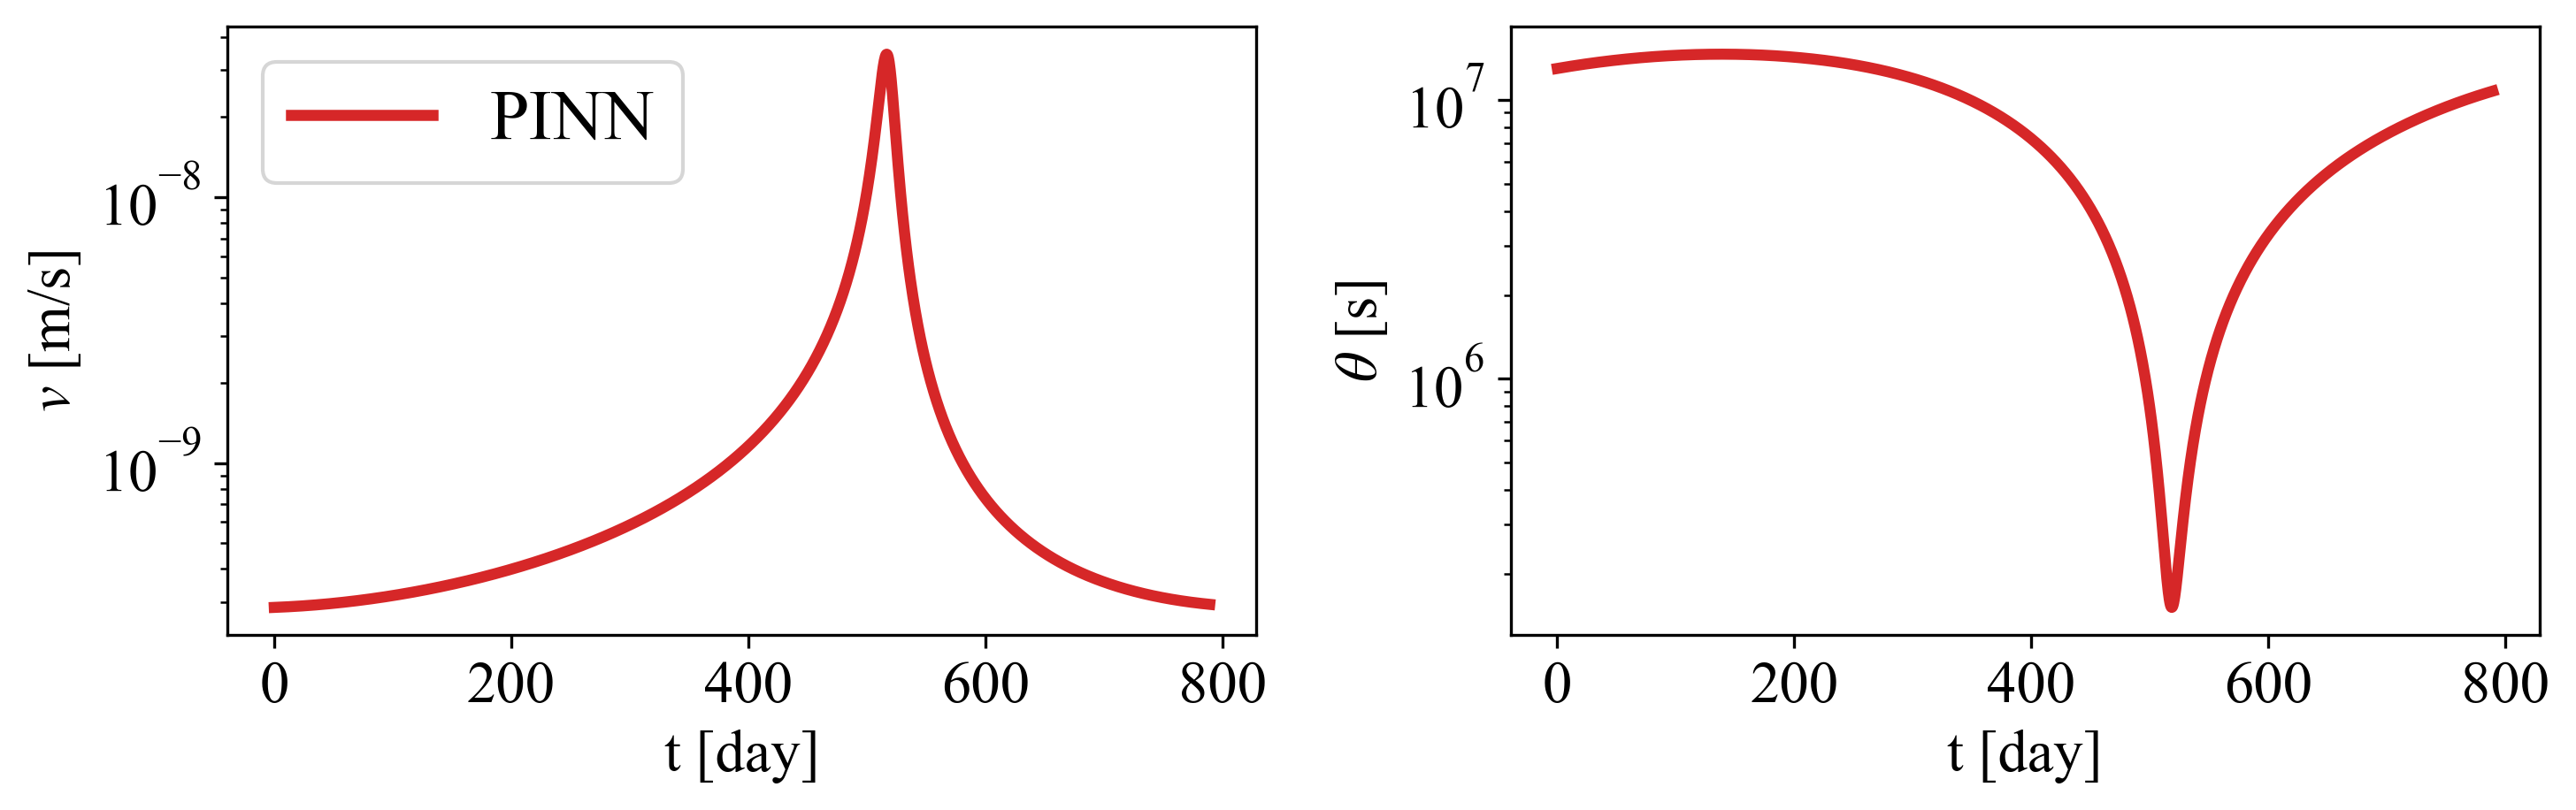

L    :  4.523e-06
Lode :  4.436e-06
Lini :  8.715e-08
Iteration :  6268


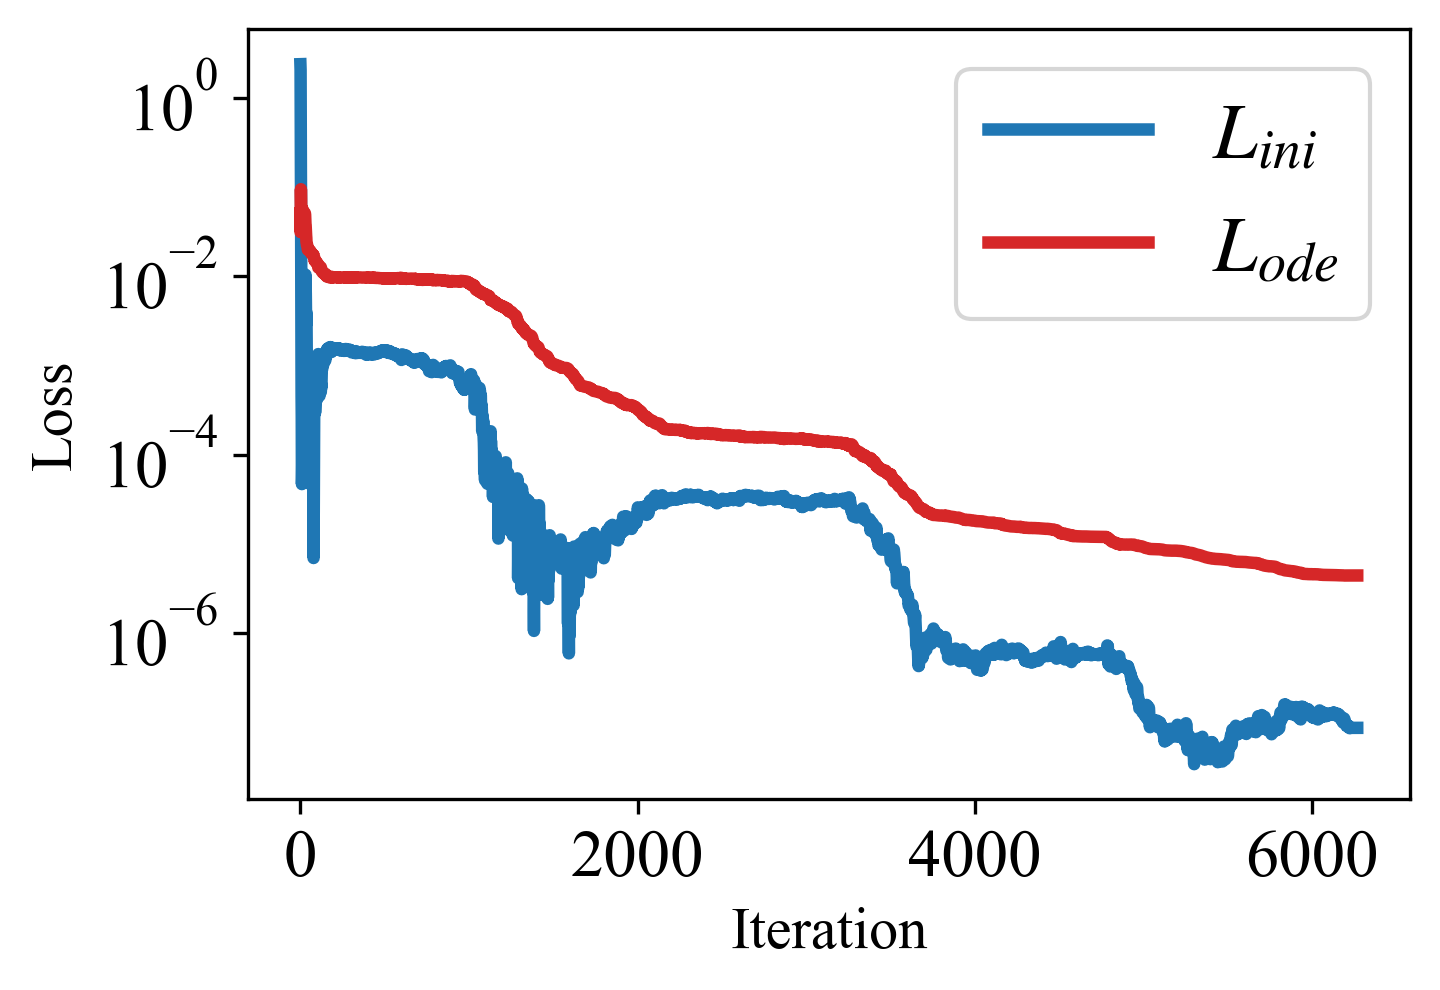

In [6]:
from Forward_Plot import Result
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
Result = Result(PINN, loss_list, filename)
Result.plot_vtheta(save)
Result.plot_loss(save)